# Applied Machine Learning: In-class Exercise 02-3

## Goal

After this exercise, you should be able to understand the importance of nested resampling when tuning ML algorithms to avoid overtuning of hyperparameters and how to apply nested resampling.

## Exercises

As a follow-up on the tuning use case, we continue with the German credit task and perform nested resampling. The purpose is to get a valid estimation of the generalization error without an optimistic bias introduced by tuning without nested resampling. For this task, we estimate the generalization error of a k-NN model implemented in scikit-learn.

### Recap: Nested Resampling
Recap the concept of nested sampling.

===SOLUTION===

Nested resampling evaluates a learner combined with a tuning strategy to correctly estimate the generalization error. Linking a tuning strategy with a learner uses the training data to find a good hyperparameter configuration (HPC). Using the same data for performance estimation and hence taking the best-estimated generalization error of the best-performing model leads to an over-optimistic estimation. This is because information on the resampling splits may favor specific HPCs (overtuning) by chance.

## The RandomizedSearchCV
For this exercise, we use the same setup as for the tuning use case with a 3-fold cross-validation, accuracy as performance measure, a random search, and a termination criterion of 40 evaluations. We define the RandomizedSearchCV and train it on the German credit task:

### Recap: RandomizedSearchCV
Recap what RandomizedSearchCV does.

===SOLUTION===

The RandomizedSearchCV class from scikit-learn combines the learner and the hyperparameter optimization (HPO) to encapsulate the learner from its hyperparameters. When fitting RandomizedSearchCV, two steps are executed: (1) perform hyperparameter tuning based on the defined search strategy and (2) take the best HPC and fit a model with those hyperparameters to the full data set.

Similar to the last exercise, we employ k-NN models as classifiers and tune two hyperparameters: $k$ and feature scaling. 


<details><summary>Hint 1:</summary>
The RandomizedSearchCV is defined by specifying the learner (e.g., pipeline with preprocessing and k-NN), resampling strategy (e.g., StratifiedKFold), scoring measure, number of iterations, and the hyperparameter search space. RandomizedSearchCV then behaves like a normal estimator. We can use .fit() to perform both tuning and model fitting on the best HPC.
</details>

In [1]:
#===SOLUTION===

import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.datasets import fetch_openml


X, y = fetch_openml("credit-g", version=1, as_frame=True, return_X_y=True)

X = pd.get_dummies(X, drop_first=True)

# By default, we simply use StandardScaler for all features; to disable scaling, it can be replaced by 'passthrough'
# Note: this simple pipeline applies StandardScaler to all features, which is not the best practice.
# We will see more fine-grained feature preprocessing in the next exercises.
pipeline = Pipeline([
    ('preprocessor', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Define the hyperparameter search space:
param_distributions = {
    'knn__n_neighbors': np.arange(1, 101),
    'preprocessor': [StandardScaler(), 'passthrough']
}

# Set up a 3-fold stratified cross-validation.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV with 40 iterations.
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=40,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the AutoTuner: tune the hyperparameters and refit the best model.
random_search.fit(X, y)

# Output the tuning results.
print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best accuracy: {random_search.best_score_:.4f}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits

Best parameters: {'preprocessor': StandardScaler(), 'knn__n_neighbors': 9}
Best accuracy: 0.7400


## Perform nested resampling

Setting the resampling strategy in `RandomizedSearchCV` defines how the hyperparameter configurations (HPCs) are internally evaluated and is hence called inner resampling. To get the final estimate of the generalization error, we have to resample the `RandomizedSearchCV` object itself. This resampling is also called outer resampling. Use `cross_validate()` to conduct a 3-fold cross-validation as the outer resampling strategy:

<details><summary>Hint 1:</summary>
As for a normal learner, we first have to define the resampling strategy and then call `cross_validate()`.
</details>

In [2]:
#===SOLUTION===

from sklearn.model_selection import StratifiedKFold, cross_validate

# Define outer (nested) 3-fold cross-validation with a fixed random seed.
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=31415)

# Perform nested resampling: the inner tuning is performed by random_search.
cv_results = cross_validate(
    random_search,
    X, y,
    cv=outer_cv,
    scoring='accuracy',
    n_jobs=-1,
    return_estimator=True
)

# Extract fold-wise accuracies and compute classification error for each fold.
outer_accuracy_scores = cv_results['test_score']
outer_classif_ce = 1 - outer_accuracy_scores

# Aggregate the classification error across folds.
aggregated_classif_ce = np.mean(outer_classif_ce)
print(f"Aggregated classification error: {aggregated_classif_ce:.6f}")

# Create and display a DataFrame with fold-wise classification errors.
fold_scores_df = pd.DataFrame({
    "fold": np.arange(1, len(outer_classif_ce) + 1),
    "classification_error": outer_classif_ce
})
print("\nFold-wise classification errors:")
print(fold_scores_df.to_string(index=False))


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Aggregated classification error: 0.261987

Fold-wise classification errors:
 fold  classification_error
    1              0.275449
    2              0.255255
    3              0.255255


## Benchmark comparison

Conduct a benchmark to compare the previously tuned k-NN model, which automatically finds the best hyperparameters, with an untuned k-NN (with randomly selected $k$ and no feature scaling) and two additional learners using their default hyperparameter values (e.g., a decision tree and a random forest without tuning them). Think about suitable learners (which you already know) and run a benchmark using `cross_validate()`. What can you observe (especially when looking at the untuned methods vs. the tuned k-NN model)?

<details><summary>Hint 1:</summary>
Use learners that are readily available in scikit-learn, such as `DecisionTreeClassifier`, `RandomForestClassifier`, and `KNeighborsClassifier`. For decision tree and random forest classifiers, no feature scaling is needed in this experiment.
</details>

<details><summary>Hint 2:</summary>
You can organize all learners into a dictionary and use a loop to perform cross-validation on each learner. Store the classification errors for later comparison (mean errors, fold-wise errors, or plots).
</details>

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Tuned k-NN - Mean classification error: 0.279
  Fold 1: 0.288
  Fold 2: 0.268
  Fold 3: 0.288
  Fold 4: 0.272

Random Forest - Mean classification error: 0.246
  Fold 1: 0.232
  Fold 2: 0.232
  Fold 3: 0.272
  Fold 4: 0.248

Decision Tree - Mean classification error: 0.315
  Fold 1: 0.312
  Fold 2: 0.312
  Fold 3: 0.332
  Fold 4: 0.304

Untuned k-NN - Mean classification error: 0.354
  Fold 1: 0.364
  Fold 2: 0.340
  Fold 3: 0.352
  Fold 4: 0.360

Benchmark Summary:
      Learner  Mean Classification Error
   Tuned k-NN                      0.279
Random Forest                      0.246
Decision Tree                      0.315
 Untuned k-NN                      0.354


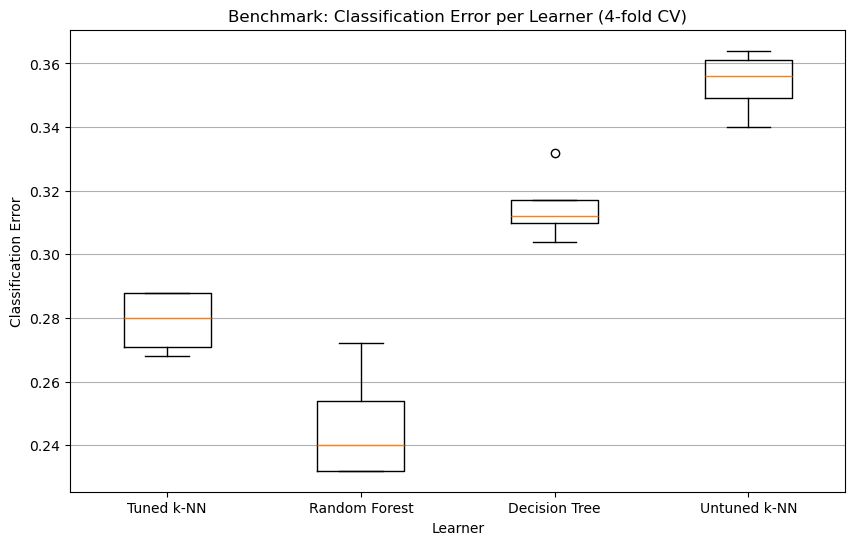

In [3]:
#===SOLUTION===

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Tuned k-NN from previous tuning (nested CV is performed internally via RandomizedSearchCV)
tuned_knn = random_search

# Untuned random forest (default parameters)
rf = RandomForestClassifier(random_state=42)

# Untuned decision tree (default parameters)
dt = DecisionTreeClassifier(random_state=42)

# Untuned k-NN: we use a pipeline with scaling for comparability.
untuned_knn = KNeighborsClassifier()

# Organize the learners in a dictionary.
learners = {
    "Tuned k-NN": tuned_knn,
    "Random Forest": rf,
    "Decision Tree": dt,
    "Untuned k-NN": untuned_knn
}

# Define the outer resampling (4-fold CV)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=31415)

# Dictionary to store benchmark results.
benchmark_results = {}

for name, learner in learners.items():
    cv_results = cross_validate(
        learner,
        X, y,
        cv=outer_cv,
        scoring='accuracy',  # we use accuracy so that classification error = 1 - accuracy.
        n_jobs=-1,
        return_estimator=False
    )
    # Compute fold-wise classification error.
    fold_errors = 1 - cv_results['test_score']
    benchmark_results[name] = {
        "fold_errors": fold_errors,
        "mean_error": np.mean(fold_errors)
    }

    print(f"{name} - Mean classification error: {benchmark_results[name]['mean_error']:.3f}")
    for i, err in enumerate(fold_errors, start=1):
        print(f"  Fold {i}: {err:.3f}")
    print()

# Create a summary table for the benchmark
summary = pd.DataFrame({
    "Learner": list(benchmark_results.keys()),
    "Mean Classification Error": [benchmark_results[name]["mean_error"] for name in benchmark_results]
})
print("Benchmark Summary:")
print(summary.to_string(index=False))

# Boxplot of fold-wise classification errors for each learner
# Prepare data in a list where each element is an array of fold errors.
data_to_plot = [benchmark_results[name]["fold_errors"] for name in learners]

plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, labels=list(learners.keys()))
plt.title("Benchmark: Classification Error per Learner (4-fold CV)")
plt.ylabel("Classification Error")
plt.xlabel("Learner")
plt.grid(axis='y')
plt.show()

Question: what is your observation?

===SOLUTION===

We observe that the random forest is very good out of the box without tuning. For k-NN the tuning has a high impact w.r.t. performance.

## Summary
* We learned how to encapsulate a learner from its hyperparameters by wrapping it in a `RandomizedSearchCV` object.

* `RandomizedSearchCV` does so by applying internal hyperparameter optimization (HPO) using an inner resampling.

* We have to additionally resample the `RandomizedSearchCV` to get valid estimations (outer resampling) and be able to compare it with other learners.

* The outer resampling that is applied to a learner that already performs resampling internally (the inner resampling) for finding the best hyperparameters is called nested resampling.